## Phase 4 Project Submission
* Student name: Simran Kaur
* Student pace: Part Time
* Scheduled project review date/time: Wednesday, January 10th.
* Instructor name: Morgan Jones
* Blog post URL: TBD

# Twitter Sentiment Analysis

## Overview
Twitter's CEO, Elon Musk, wants to add a group of emojis as responses to tweets. Currently the only emoji available is a heart. He wants to understand the overall sentiments of tweets users share, to determine which emojis would be best to add. 

This analysis will use Natural Language Processing ("NLP") to understand overall tweet sentiment. 

## Importing Libraries

In [256]:
# Data manipulation 
import pandas as pd 
import numpy as np 

# Data visualization
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 

# Libraries for text preprocessing
import re # RegEx for removing non-letter characters
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from wordcloud import WordCloud

# Libraries for modeling
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report,f1_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Algorithms for using supervised learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

#filter warnings
import warnings
warnings.filterwarnings('ignore')

## Obtaining & Understanding the Data

Data was taken from [data.world](https://data.world/crowdflower/brands-and-product-emotions). It contains over 9,000 different tweets with the device it was shared from as well as if there is a positive, negative or neutral emotion to the tweet. 

This data will be helpful in the analysis as it has emotions tagged to tweets. 

In [257]:
# Read data from csv file & create dataframe. Preview first 10 rows.
df = pd.read_csv("tweet_data.csv",encoding='latin-1')
df.head(10)

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5  @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                NaN   
7  #SXSW is just starting, #CTIA is around the co...   
8  Beautifully smart and simple idea RT @madebyma...   
9  Counting down the days to #sxsw plus strong Ca...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   
5                             NaN   
6                             NaN   
7                         Android   
8              iPad or iPhone App   
9                           Apple   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion  
5                 No emotion toward brand or product  
6                 No emotion toward brand or product  
7                                   Positive emotion  
8                                   Positive emotion  
9                                   Positive emotion

In [258]:
# Assess dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [259]:
# Get shape to determine number of rows & columns
df.shape

(9093, 3)

In [260]:
# Get different values in the "emotion_in_tweet_is_directed_at" column
df.emotion_in_tweet_is_directed_at.unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [261]:
# Get different values in the "is_there_an_emotion_directed_at_a_brand_or_product" column
df.is_there_an_emotion_directed_at_a_brand_or_product.unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

## Data Prep
This section prepares the data for EDA and modeling. Columns will be renamed and the dataset will be checked for duplicated rows & missing values.

In [262]:
# Rename columns
df.rename(columns={"tweet_text":"tweet"},inplace = True)
df.rename(columns={"emotion_in_tweet_is_directed_at":"device"},inplace = True)
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product":"emotion"},inplace = True)

In [263]:
# Check for duplicated rows
df.duplicated().sum()

22

In [264]:
# Drop 22 duplicated rows
df.drop_duplicates(inplace=True)

In [265]:
# Confirm there are no more duplicates
df.duplicated().sum()

0

In [266]:
# Check for missing values
percent_missing = round(df.isnull().sum() * 100 / len(df),3)
missing_value_df = pd.DataFrame({'Missing_Percentage': percent_missing})
missing_value_df.sort_values(by="Missing_Percentage",ascending=False).head(20)

Missing_Percentage
device               63.819
tweet                 0.011
emotion               0.000

In [267]:
# Drop device column as 64% is missing
df.drop(['device'],axis=1,inplace=True)

In [268]:
# Drop the tweet rows that are missing
df.dropna(subset=['tweet'],inplace=True)

## Explanatory Data Analysis ("EDA")

### Feature Engineering the "Emotion" Feature

In [269]:
# Check the value counts in the "emotion" column
df['emotion'].value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

In [270]:
# Combine "No emotion towards brand or product" & "I can't tell"
df["emotion"] = np.where(df["emotion"].str.contains("I can't tell|No emotion toward brand or product"),
                         'Neutral emotion',df["emotion"])

In [271]:
# Recheck "emotion" value counts
df['emotion'].value_counts()

Neutral emotion     5531
Positive emotion    2970
Negative emotion     569
Name: emotion, dtype: int64

### Feature Engineering the "Tweet" Feature

In [272]:
# Define cleanup rules
def cleanTweets(tweets):
    twt = tweets.lower() #convert all letters to lower case
    twt = re.sub("@[A-Za-z0-9_]+","", twt) #remove mentions
    twt = re.sub(r"http\S+", "", twt) #remove url's https tags
    twt = re.sub(r"www.\S+", "", twt) #remove url's www tags
    twt = re.sub("[^a-z0-9]"," ", twt) #remove non-alphanumeric characters
    twt = re.sub('[\s]+', ' ', twt) #Remove additional white spaces
    return twt

In [273]:
# Apply cleanup rules to "tweet" column
cleantext=[]
for item in tqdm(df['tweet']):
    twt = cleanTweets(item)
    cleantext += [twt]
df['clean_tweet']=cleantext
df

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9070/9070 [00:00<00:00, 40409.70it/s]


tweet           emotion  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...  Negative emotion   
1     @jessedee Know about @fludapp ? Awesome iPad/i...  Positive emotion   
2     @swonderlin Can not wait for #iPad 2 also. The...  Positive emotion   
3     @sxsw I hope this year's festival isn't as cra...  Negative emotion   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...  Positive emotion   
...                                                 ...               ...   
9088                      Ipad everywhere. #SXSW {link}  Positive emotion   
9089  Wave, buzz... RT @mention We interrupt your re...   Neutral emotion   
9090  Google's Zeiger, a physician never reported po...   Neutral emotion   
9091  Some Verizon iPhone customers complained their...   Neutral emotion   
9092  ¬å√è¬°¬é√è√†¬ä√º_¬ã¬Å√ä¬ã¬Å√é¬ã¬Å√í¬ã¬Å¬£¬ã¬Å√Å¬ã√¢√¢¬ã¬Å_¬ã¬Å¬£¬ã¬Å¬è¬ã√¢_¬ã√õ√¢RT @...   Neutral emotion   

                                            clean_tweet  
0      i have a 3g iphone after 3 hrs tweeting at ri...  
1      know about awesome ipad iphone app that you l...  
2      can not wait for ipad 2 also they should sale...  
3      i hope this year s festival isn t as crashy a...  
4      great stuff on fri sxsw marissa mayer google ...  
...                                                 ...  
9088                         ipad everywhere sxsw link   
9089  wave buzz rt we interrupt your regularly sched...  
9090  google s zeiger a physician never reported pot...  
9091  some verizon iphone customers complained their...  
9092      rt google tests check in offers at sxsw link   

[9070 rows x 3 columns]

In [274]:
# Drop uncleaned "tweet" column
df = df.drop(['tweet'],axis=1)
df.head()

emotion                                        clean_tweet
0  Negative emotion   i have a 3g iphone after 3 hrs tweeting at ri...
1  Positive emotion   know about awesome ipad iphone app that you l...
2  Positive emotion   can not wait for ipad 2 also they should sale...
3  Negative emotion   i hope this year s festival isn t as crashy a...
4  Positive emotion   great stuff on fri sxsw marissa mayer google ...

### WordClouds

In [275]:
# Define function to create a WordCloud
def create_corpus_df(tweet, emotion):
    corpus=[]
    
    for x in df[df['emotion']==emotion]['clean_tweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

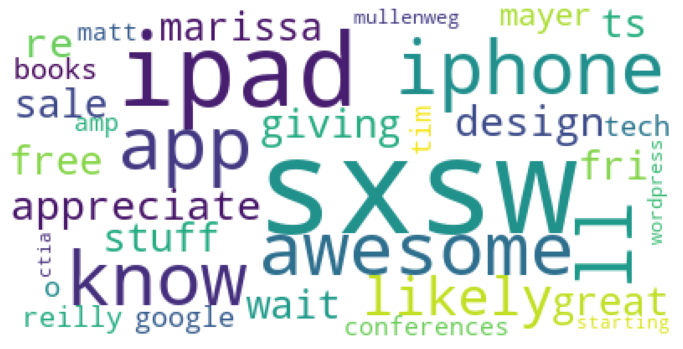

In [276]:
# WordCloud for "Positive emotion" tweets 
corpus_new1=create_corpus_df(df,'Positive emotion')
len(corpus_new1)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

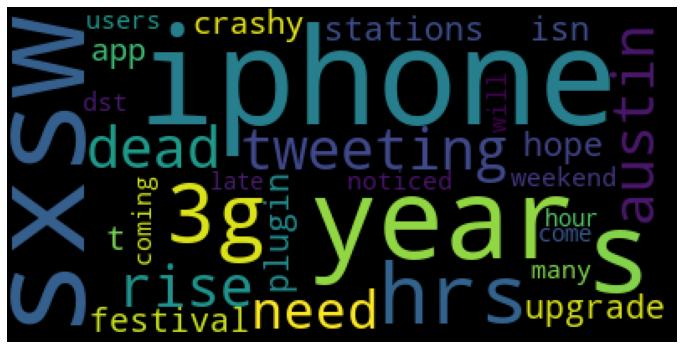

In [277]:
# WordCloud for "Negative emotion" tweets 
corpus_new2=create_corpus_df(df,'Negative emotion')
len(corpus_new2)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new2[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

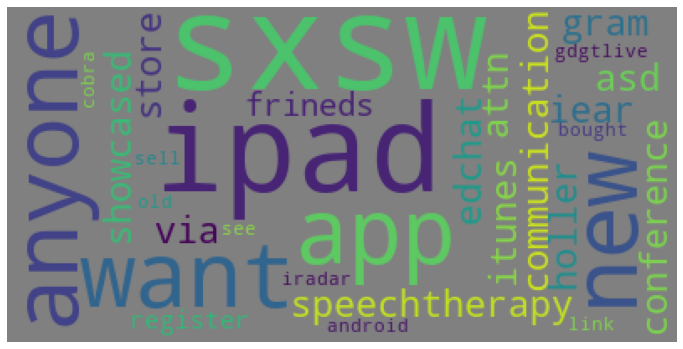

In [278]:
# WordCloud for "Neutral emotion" tweets 
corpus_new3=create_corpus_df(df,'Neutral emotion')
len(corpus_new3)

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='gray',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new3[:60]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

* SXSW is mentioned in all three WordClouds. This is understandable as the data is from when the South by SouthWest film festival took place. 
* Iphone is mentioned in both the positive and negative WordClouds.

### Tweet Length Analysis

In [279]:
# Create a new feature "tweet_length" to show the lengths of the tweets
df['tweet_length'] = df['clean_tweet'].apply(len) 
df.head()

emotion                                        clean_tweet  \
0  Negative emotion   i have a 3g iphone after 3 hrs tweeting at ri...   
1  Positive emotion   know about awesome ipad iphone app that you l...   
2  Positive emotion   can not wait for ipad 2 also they should sale...   
3  Negative emotion   i hope this year s festival isn t as crashy a...   
4  Positive emotion   great stuff on fri sxsw marissa mayer google ...   

   tweet_length  
0           110  
1           116  
2            65  
3            75  
4           111

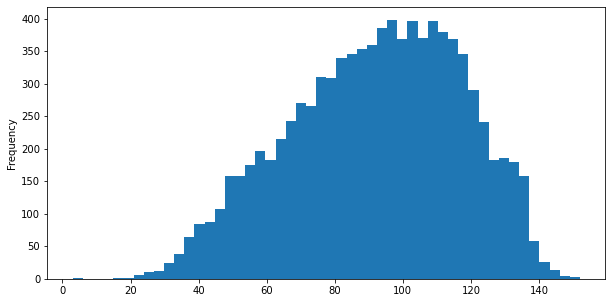

In [280]:
# Plot distribution for tweet_length
plt.figure(figsize=(10,5))
df['tweet_length'].plot(bins=50, kind='hist'); 

* The distribution is normal and seems to be slightly skewed to the right side. 
* The left tail is heavier, which makes sense as tweets are meant to be sweet and simple. The left tail is an indicator of tweets with fewer characters.

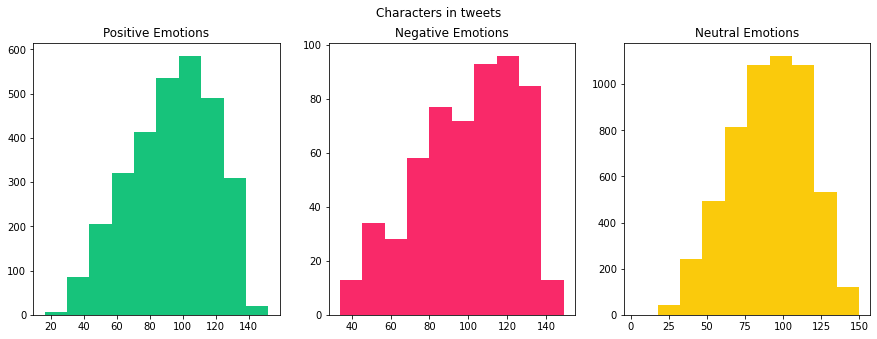

In [281]:
# Plot histograms for the characters in each emotion
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df[df['emotion']=="Positive emotion"]['tweet_length']
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Emotions')

tweet_len=df[df['emotion']=="Negative emotion"]['tweet_length']
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Emotions')

tweet_len=df[df['emotion']=="Neutral emotion"]['tweet_length']
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Emotions')

fig.suptitle('Characters in tweets')
plt.show()

* Neutral emotions has the highest character count and understandable so. That emotion has the most number of tweets. 
* Between positive and negative tweets, character count for positive tweets are higher. 
* All histograms look normally distrubuted, with a slight skew to the right side.

In [282]:
# Drop tweet_length as it is no longer needed. Recheck dataframe. 
df.drop(['tweet_length'],axis=1,inplace=True)
df.head()

emotion                                        clean_tweet
0  Negative emotion   i have a 3g iphone after 3 hrs tweeting at ri...
1  Positive emotion   know about awesome ipad iphone app that you l...
2  Positive emotion   can not wait for ipad 2 also they should sale...
3  Negative emotion   i hope this year s festival isn t as crashy a...
4  Positive emotion   great stuff on fri sxsw marissa mayer google ...

### N-Gram Analysis
* N-gram modeling is a techniques used to convert text from an unstructured format to a structured format.
* N-grams of texts are extensively used in text mining and NLP tasks. They are basically a set of co-occurring words within a given window and when computing the n-grams, you typically move one word forward.
* In the fields of computational linguistics and probability, an n-gram (sometimes also called Q-gram) is a contiguous sequence of n items from a given sample of text or speech.
* A bigram (n=2) analysis over the tweets.

In [283]:
# Define function to get n-grams
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

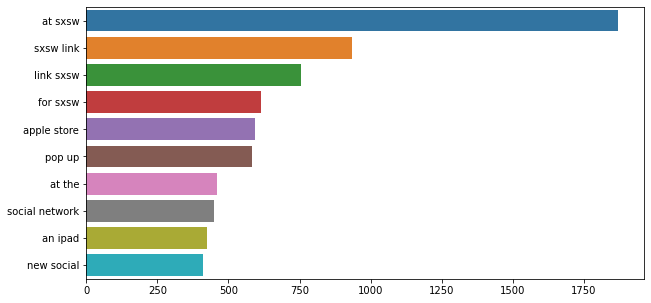

In [284]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(df['clean_tweet'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x);

### Removing Punctions
* Punctuation marks such as commas, apostrophes, quotations and question marks will be removed from the texts.

In [206]:
# Define function to remove punctuation
def remove_punctuation(description):
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)

In [207]:
# Apply function
df['clean_tweet'] = df['clean_tweet'].apply(remove_punctuation)
df.head()

emotion                                        clean_tweet
0  Negative emotion   i have a 3g iphone after 3 hrs tweeting at ri...
1  Positive emotion   know about awesome ipad iphone app that you l...
2  Positive emotion   can not wait for ipad 2 also they should sale...
3  Negative emotion   i hope this year s festival isn t as crashy a...
4  Positive emotion   great stuff on fri sxsw marissa mayer google ...

### Removing Emojis

In [285]:
# Define function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake üòîüòî")

'Omg another Earthquake '

In [286]:
# Apply function
df['clean_tweet_text']=df['clean_tweet'].apply(lambda x: remove_emoji(x))

### Count Vectorizer
* In order to use textual data for predictive modeling, the text must be parsed to remove certain words ‚Äì this process is called tokenization. These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).
* Countvectorizer is a method to convert text to numerical data.
* Scikit-learn‚Äôs CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.

In [212]:
vectorizer = CountVectorizer()
vectorizer.fit(df['clean_tweet'])
vector = vectorizer.transform(df['clean_tweet'])
print(vector.shape)

(9070, 9569)


### TF-IDF
* TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.
* The TF-IDF algorithm is used to weigh a keyword in any content and assign importance to that keyword based on the number of times it appears in the document.
* TF is a measure of how often a phrase appears in a document, and IDF is about how important that phrase is. The multiplication of these two scores makes up a TF-IDF score.

In [217]:
tfidf_converter = TfidfTransformer()
X_tfidf = tfidf_converter.fit_transform(vector).toarray()

In [218]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Train-Test Split and Applying SMOTE to "emotion" Feature
* SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.
* The technique aims to balance class distribution by randomly increasing minority class examples by replicating them.

Neutral emotion     5531
Positive emotion    2970
Negative emotion     569
Name: emotion, dtype: int64


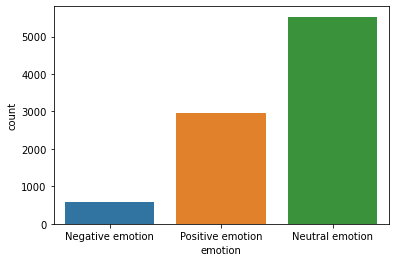

In [219]:
# Check counts for the "emotion" feature
print(df.emotion.value_counts())
sns.countplot(data=df, x='emotion');

In [287]:
# Test-train split
X = X_tfidf
y = df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 123)

In [221]:
# Apply SMOTE
sm = SMOTE(k_neighbors=5, random_state=123)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape)) 
print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))

Before OverSampling, the shape of X_train: (6802, 9569)
Before OverSampling, the shape of y_train: (6802,)
After OverSampling, the shape of X_train_over: (12426, 9569)
After OverSampling, the shape of y_train_over: (12426,)


Neutral emotion     4142
Positive emotion    4142
Negative emotion    4142
Name: emotion, dtype: int64


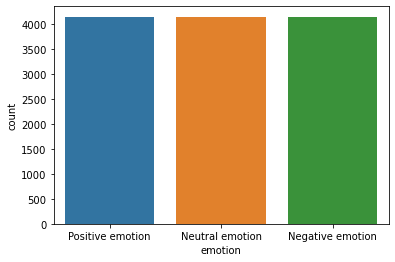

In [222]:
# Recheck counts for "emotion"
y_train_over_df = y_train_over.to_frame()
print(y_train_over_df.emotion.value_counts())
sns.countplot(data=y_train_over_df, x='emotion');